## 4th assignment (neural nets for NLP)
- #### Dimitris Georgiou - DS3517004
- #### Stratos Gounidellis - DS3517005
- #### Natasa Farmaki - DS3517018

In [2]:
# import necessary libraries

import csv
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy.sparse import vstack, hstack
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from matplotlib.font_manager import FontProperties
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline
np.random.seed()
import random
import tensorflow as tf
tf.reset_default_graph()
from keras.models import Sequential
from keras import backend as K
from keras.layers import Input, Dense, Activation, Bidirectional, Dropout
from keras.layers.core import Lambda, Reshape, Masking
from keras.layers.recurrent import GRU
from keras.models import Model
from keras import regularizers
from pprint import pprint
from keras.layers import LSTM 
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import metrics
from keras.utils import np_utils


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The Enron Corpus is a large database of over 600,000 emails generated by 158 employees of the Enron Corporation and acquired by the Federal Energy Regulatory Commission during its investigation after the company's collapse.

The Enron data was originally collected at Enron Corporation headquarters in Houston during two weeks in May 2002 by Joe Bartling, a litigation support and data analysis contractor working for Aspen Systems, now Lockheed Martin, whom the Federal Energy Regulatory Commission (FERC) had hired to preserve and collect the vast amounts of data in the wake of the Enron Bankruptcy in December 2001. In addition to the Enron employee emails, all of Enron's enterprise database systems, hosted in Oracle databases on Sun Microsystems servers, were also captured and preserved including its online energy trading platform, EnronOnline.

In the current subset we used a subset of the above dataset with 5172 pre-processed emails (3672 legitimate emails and 1500 spam emails). That subset can be found [here](http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron1.tar.gz).

In [3]:
ham_path = "enron1\\ham"
spam_path="enron1\\spam"
onlyfiles = [f for f in listdir(ham_path) if isfile(join(ham_path, f))]
messages = pd.DataFrame(columns=["label", "message"])
for mail in onlyfiles:
    file = open(ham_path + "\\" + mail, "r") 
    messages = messages.append({"label": 'ham' , "message": file.read()},
                               ignore_index=True)
    
print ("Legitimate emails:", len(onlyfiles))
        
onlyfiles = [f for f in listdir(spam_path) if isfile(join(spam_path, f))]
for mail in onlyfiles:
    file = open(spam_path + "\\" + mail, "r", errors='ignore') 
    messages = messages.append({"label": 'spam' , "message": file.read()},
                               ignore_index=True)
    
print ("Spam emails:", len(onlyfiles))


Legitimate emails: 3672
Spam emails: 1500


Split the dataset into training and test set with test size equal to the thirty percent (30%) of the initial dataset (3620 training data and 1552 test data). Additionally, the label is encoded with values 0 and 1, with 0 standing for "ham" and 1 standing for "spam".

In [4]:
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'],
                                                                messages['label'],
                                                                test_size=0.3,
                                                                random_state=2018)

le = preprocessing.LabelEncoder()
le.fit(label_train)
label_train = le.transform(label_train)
label_test = le.transform(label_test)


Convert the collection of the to a sparse matrix of TF-IDF features. We use unigrams, bigrams and trigrams. When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold, i.e. 10 in our case. This value is also called cut-off in the literature. Apart from the TF-IDF features we utilize also the length of each email as a feature.


In [73]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                             min_df=10)

X_train = vectorizer.fit_transform(msg_train)
X_test = vectorizer.transform(msg_test)

msg_train_len = [len(message) for message in msg_train]
msg_test_len = [len(message) for message in msg_test]
X_train = hstack((X_train, np.array(msg_train_len)[:, None])).A
X_test = hstack((X_test, np.array(msg_test_len)[:, None])).A


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Normalize the features to be between -1 and 1. This is a significant pre-processing step especially for the SVD method following later.

In [74]:
normalizer = MinMaxScaler(feature_range=(0.000001, 1.0))
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)


Compute Receiver operating characteristic. In statistics, a receiver operating characteristic curve, i.e. ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. 


In [75]:
def roc_curve_plot(label_test, predictions):
    false_positive_rate, recall, thresholds = roc_curve(label_test,
                                                        predictions)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')
    plt.show()


Compute confusion matrix to evaluate the accuracy of a classification. In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix,is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).

In [76]:
def conf_matrix(label_test, predictions):
    confusion = confusion_matrix(label_test, predictions)
    print(confusion)
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Compute metrics (f1-score & accuracy) for the classifier as it is trained in an increasing number of training data. The metrics will be later used to draw the learning curves. 


In [77]:
def calc_metrics(model, X_train, label_train, X_test, label_test, method):
    train_x_s_s, train_y_s_s = X_train, label_train
    test_x_s_s, test_y_s_s = X_test, label_test
    
    results = {}
    results['train_size'] = []
    results['on_test_acc'] = []
    results['on_train_acc'] = []

    results['on_test_f1'] = []
    results['on_train_f1'] = []

    for i in range(1, 11):
        if(i==10):
            train_x_part = train_x_s_s
            train_y_part = train_y_s_s
        else:
            if (method == "tfidf"):
                to = int(i*(train_x_s_s.shape[0]/10))
            
                train_x_part = train_x_s_s[0: to, :]
            else:
                to = int(i*(len(train_x_s_s)/10))
                train_x_part = train_x_s_s[0: to]
            train_y_part = train_y_s_s[0: to]
        if (method == "tfidf"):
            print(train_x_part.shape)
            results['train_size'].append(train_x_part.shape[0])
        else:
            print(len(train_x_part))
            results['train_size'].append(len(train_x_part))

        result = benchmark(model, train_x_part, train_y_part, 
                           test_x_s_s, test_y_s_s)

        results['on_test_acc'].append(result['accuracy'])
        results['on_test_f1'].append(result['f1'])
        result = benchmark(model, train_x_part, train_y_part, 
                           train_x_part, train_y_part)

        results['on_train_acc'].append(result['accuracy'])
        results['on_train_f1'].append(result['f1'])
    return results


Plot precision-recall curve. The trade-off between precision and recall can be observed using the precision-recall curve, and an appropriate balance between the two obtained. Depending on the requirement (high precision at the cost of recall, or high recall with lower precision), an appropriate algorithm can be chosen.


In [78]:
def learning_curves(results, metric, method):
    fontP = FontProperties()
    fontP.set_size('small')
    fig = plt.figure()
    fig.suptitle('Learning Curves - ' + method, fontsize=17)
    ax = fig.add_subplot(111)
    ax.axis([300, 3800, 0.8, 1.1])
    if method == "K-Nearest-Neighbors":
        ax.axis([300, 3800, 0.4, 1.1])
    if metric == "accuracy":
        line_up, = ax.plot(results['train_size'], results['on_train_acc'],
                           'o-', label='Accuracy on Train')
        line_down, = ax.plot(results['train_size'], results['on_test_acc'],
                             'o-', label='Accuracy on Test')
        plt.ylabel('Accuracy', fontsize=13)

        plt.legend([line_up, line_down], ['Accuracy on Train', 'Accuracy on Test'],
                   prop=fontP)
    else:
        line_up, = ax.plot(results['train_size'], results['on_train_f1'],
                           'o-', label='F1-score on Train')
        line_down, = ax.plot(results['train_size'], results['on_test_f1'],
                             'o-', label='F1-score on Test')
        plt.ylabel('F1-score', fontsize=13)
        plt.legend([line_up, line_down], ['F1-score on Train', 'F1-score on Test'],
                   prop=fontP)

    plt.xlabel('Number of training instances', fontsize=13)
    plt.grid(True)


In [79]:
def benchmark(model, X_train, y_train, X_test, y_test):

    model.fit(
    X_train,                      
    y_train,
    epochs=20,
    batch_size=32,
    verbose=0,
    validation_split=0.1
    )

    pred = model.predict_classes(np.array(X_test))
    f1 = skmetrics.f1_score(y_test, pred, average='weighted')
    accuracy = skmetrics.accuracy_score(y_test, pred)
    result = {'f1' : f1, 'accuracy' : accuracy, 'train size' : len(y_train),
              'test size' : len(y_test), 'predictions': pred }
    return result


In [80]:
def prec_rec_curve(X_test, label_test, model):

    y_score = model.predict_proba(np.array(X_test))

    average_precision = average_precision_score(label_test, y_score)

    precision, recall, thresholds = precision_recall_curve(label_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()


In [81]:
def eval_nnmodel(model, X_train, y_train, X_test, y_test):
    history = model.fit(
        X_train,                      
        label_train,
        epochs=10,
        batch_size=82,
        verbose=0,
        validation_split=0.1
    )

    score_test = model.evaluate(
        X_test,
        label_test,
        batch_size=32,
        verbose=0
    )

    score_train = model.evaluate(
        X_train,
        label_train,
        batch_size=32,
        verbose=0
    )

    # use to yield probability distribution over the categories
    # model.predict_proba(np.array([X_test[0]]))[0]

    # use to yield the predicted classes
    # model.predict_classes(np.array([X_test[0]]))[0] == y_test[0]
    print('Train binary_crossentropy:', score_train[0])
    print('Train mean_absolute_error:', score_train[1])
    print('Train accuracy:', score_train[2])
    
    predictions = model.predict_classes(np.array(X_test))
    print('\nTest binary_crossentropy:', score_test[0])
    print('Test mean_absolute_error:', score_test[1])
    print('Test accuracy:', score_test[2])
    print('Test precision:', skmetrics.precision_score(y_test, predictions))
    print('Test recall:', skmetrics.recall_score(y_test, predictions))
    print('Test f1 score:', skmetrics.f1_score(y_test, predictions))

    return predictions

### Classifiers 

### Baseline Classifier

To get a clear picture of a classifier’s performance, it is common to compare its accuracy or error rate to those of a simplistic “baseline” approach. In our case, we used the most simple classifier. As stated above the dataset is imbalanced, which means that the legitimate messages are far more than the spam messages. So the most simple classifier would just classify all emails as legitimate. In other words, legitimate messages are (correctly) never blocked, and spam messages (mistakenly) always pass.

Additionally, since the dataset is imbalanced we should employ an accurate and reliable metric to compare each of the implemented classifiers with the baseline classifier. Thus, we calculated the weighted versions of accuracy and error for the baseline classifier giving more weight to the number of the legitimate emails. In our case, we set the weight to two (2).


In [82]:
nspam = len(label_test[label_test == 1])
nham = len(label_test[label_test == 0])

l = 2
wb_accuracy = (l * nham) / ((l * nham) + nspam)
wb_error = nspam / ((l * nham) + nspam)

print ("Accuracy (baseline classifier):", wb_accuracy)
print ("Error (baseline classifier):", wb_error)


Accuracy (baseline classifier): 0.8352720450281426
Error (baseline classifier): 0.1647279549718574


### Multilayer Perceptron (MLP) - TFIDF

A multilayer perceptron (MLP) is a class of feedforward artificial neural network. An MLP consists of at least three layers of nodes. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. In our case we use as features the sparse matrix of TF-IDF features from unigrams, bigrams and trigrams. The activation function is sigmoid while as metric is used the binary_crossentropy as we only have two possible classes, the spam and legitmate emails. 

In [83]:
def mlp_tfidf():

    max_words = 7468

    batch_size = 82
    nb_epoch = 10
    nodes = 512
    act_func='relu'
    print('Building model...')

    model = Sequential()

    model.add(Dense(nodes, input_shape=(max_words,)))
    model.add(Activation(act_func))

    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print(model.summary())
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.mae,
                                                                         metrics.binary_accuracy])

    return model


In [84]:
# calculate class predictions based on the model trained on the whole training set
model_tfidf = mlp_tfidf()
predictions = eval_nnmodel(model_tfidf, X_train, label_train, X_test, label_test)


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 512)               3824128   
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 513       
_________________________________________________________________
activation_18 (Activation)   (None, 1)                 0         
Total params: 3,824,641
Trainable params: 3,824,641
Non-trainable params: 0
_________________________________________________________________
None
Train binary_crossentropy: 0.008207290809067024
Train mean_absolute_error: 0.0038629773554789883
Train accura

Calculate the weighted versions of accuracy and error for the logistic regression classifier giving more weight to the number of the legitimate emails, the false postive (legitimate -> spam) and the true negative (legitimate -> legitimate). In our case, we set the weight to two (2), as state also above.

Calculate the the ratio of the weighted error of the baseline classifier to the weighted error of the logistic regression classifier. This is the total cost ratio (TCR). The higher TCR, the better our classifier is in comparison to the baseline classifier.

In [22]:
tn, fp, fn, tp = confusion_matrix(label_test, predictions).ravel()
wlog_accuracy = ((l * tn) + tp) / ((l * nham) + nspam)

wlog_error = ((l * fp) + fn) / ((l * nham) + nspam)
tcr = wb_error / wlog_error
print("Total cost ratio - MLP TF-IDF vs. baseline classifier:", tcr)


Total cost ratio - MLP TF-IDF vs. baseline classifier: 11.552631578947368


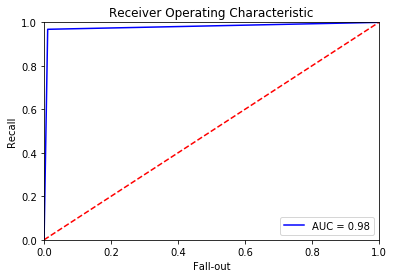

In [23]:
roc_curve_plot(label_test, predictions)


[[1101   12]
 [  14  425]]


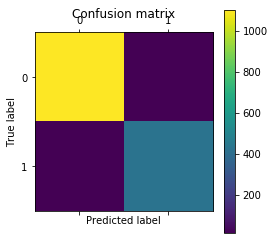

In [24]:
conf_matrix(label_test, predictions)


In [27]:
results_tfidfnn = calc_metrics(model_tfidf, X_train, label_train, X_test, label_test, "tfidf")


(362, 7468)
(724, 7468)
(1086, 7468)
(1448, 7468)
(1810, 7468)
(2172, 7468)
(2534, 7468)
(2896, 7468)
(3258, 7468)
(3620, 7468)


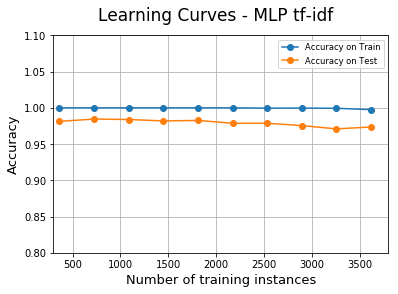

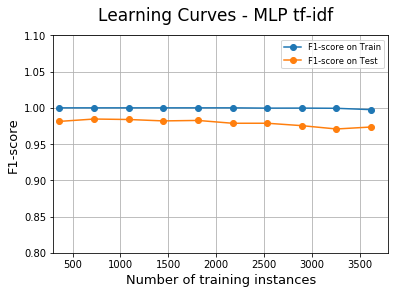

In [28]:
learning_curves(results_tfidfnn, "accuracy", "MLP tf-idf")
learning_curves(results_tfidfnn, "f1-score", "MLP tf-idf")


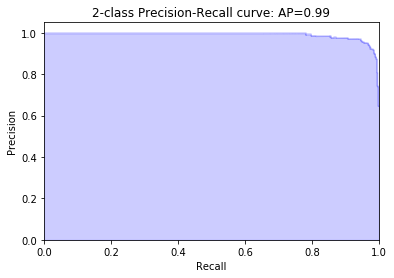

In [29]:
prec_rec_curve(X_test, label_test, model_tfidf)


### Pre - processing for the other Neural Networks

In [69]:
labels = messages['label']
emails = messages['message']

num_max = 2000
le = LabelEncoder()
tags = le.fit_transform(labels)

tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(emails)

# split the text on tokens and keep the most common words
mat_texts = tok.texts_to_matrix(emails , mode='count')
X_train, X_test, y_train, y_test = train_test_split(emails, tags,
                                                    test_size = 0.3,
                                                    random_state=2018)
mat_texts_tr = tok.texts_to_matrix(X_train, mode='count')
mat_texts_tst = tok.texts_to_matrix(X_test, mode='count')

max_len = 500
# turn the input into numerical arrays
X_train = tok.texts_to_sequences(X_train)
X_test = tok.texts_to_sequences(X_test)

# pad_sequences is used to ensure that 
# all sequences in a list have the same length.
cnn_texts_mat = sequence.pad_sequences(X_train, maxlen=max_len)
cnn_texts_mat_tst = sequence.pad_sequences(X_test, maxlen=max_len)


### Multilayer Perceptron (MLP)

In [71]:
def mlp_model():
    num_max = 2000
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.binary_accuracy])
    return model
    
mlp_nnmodel = mlp_model()
predictions_mlp = eval_nnmodel(mlp_nnmodel, mat_texts_tr, y_train, mat_texts_tst, y_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 512)               1024512   
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 257       
Total params: 1,156,097
Trainable params: 1,156,097
Non-trainable params: 0
_________________________________________________________________
Train binary_crossentropy: 0.17719158557431694
Train mean_absolute_error: 0.024548948197077067
Train accuracy: 0.9767955801104973

T

In [54]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_mlp).ravel()
wmlp_accuracy = ((l * tn) + tp) / ((l * nham) + nspam)

wmlp_error = ((l * fp) + fn) / ((l * nham) + nspam)
tcr = wb_error / wmlp_error
print("Total cost ratio - MLP vs. baseline classifier:", tcr)


Total cost ratio - MLP vs. baseline classifier: 11.256410256410255


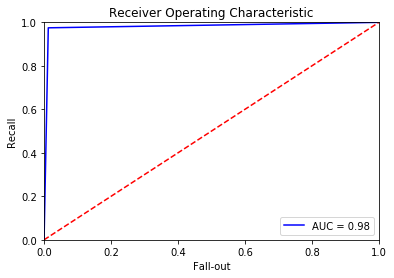

In [55]:
roc_curve_plot(y_test, predictions_mlp)


In [56]:
results_mlp = calc_metrics(mlp_nnmodel, mat_texts_tr, y_train, mat_texts_tst, y_test, "other")


362
724
1086
1448
1810
2172
2534
2896
3258
3620


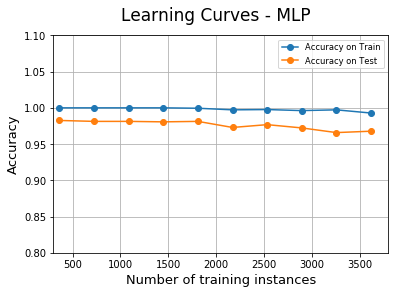

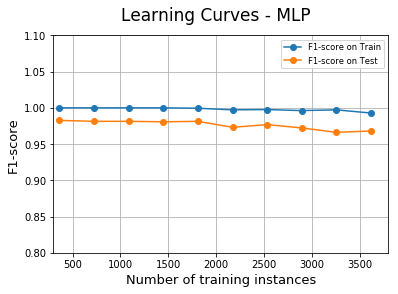

In [57]:
learning_curves(results_mlp, "accuracy", "MLP")
learning_curves(results_mlp, "f1-score", "MLP")


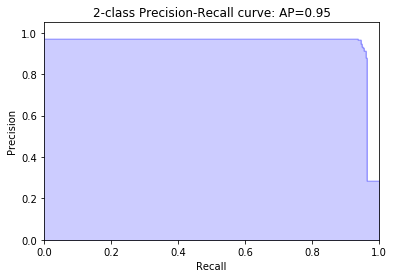

In [58]:
prec_rec_curve(mat_texts_tst, y_test, mlp_nnmodel)


### Convolutional neural network (CNN)

In machine learning, a convolutional neural network (CNN, or ConvNet) is a class of deep, feed-forward artificial neural networks that has successfully been applied to analyzing visual imagery.

CNNs use a variation of multilayer perceptrons designed to require minimal preprocessing. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on their shared-weights architecture and translation invariance characteristics.

In [72]:
def cnn_model():   
    model = Sequential()
    model.add(Embedding(2000,20,input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.binary_accuracy])
    return model

cnn_nnmodel = cnn_model()
predictions_cnn = eval_nnmodel(cnn_nnmodel, cnn_texts_mat, y_train, cnn_texts_mat_tst, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 20)           40000     
_________________________________________________________________
dropout_20 (Dropout)         (None, 500, 20)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 498, 64)           3904      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
__________

In [60]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_cnn).ravel()
wcnn_accuracy = ((l * tn) + tp) / ((l * nham) + nspam)

wcnn_error = ((l * fp) + fn) / ((l * nham) + nspam)
tcr = wb_error / wcnn_error
print("Total cost ratio - CNN vs. baseline classifier:", tcr)


Total cost ratio - CNN vs. baseline classifier: 6.36231884057971


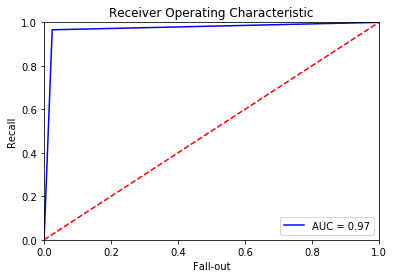

In [61]:
roc_curve_plot(y_test, predictions_cnn)


In [62]:
results_cnn = calc_metrics(cnn_nnmodel, cnn_texts_mat, y_train, cnn_texts_mat_tst, y_test, "other")


362
724
1086
1448
1810
2172
2534
2896
3258
3620


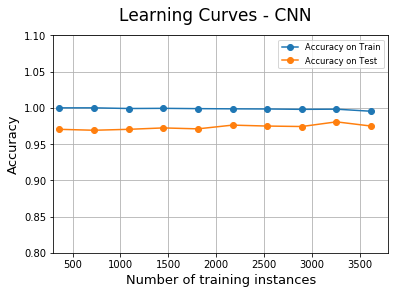

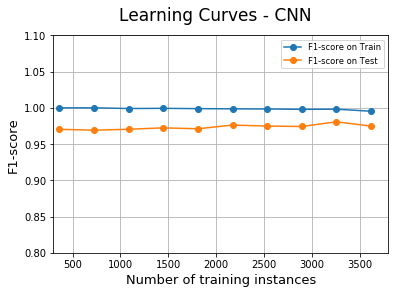

In [63]:
learning_curves(results_cnn, "accuracy", "CNN")
learning_curves(results_cnn, "f1-score", "CNN")


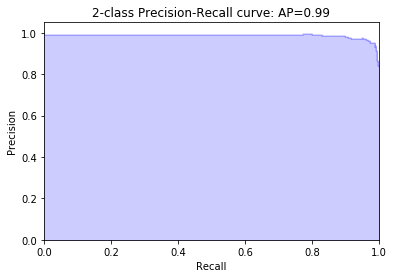

In [64]:
prec_rec_curve(cnn_texts_mat_tst, y_test, cnn_nnmodel)
